In [1]:
import torchvision 
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms   
import torch.optim as optim
from torchvision.transforms import RandomRotation
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from PIL import Image
from numpy.linalg import norm
from torch.cuda.random import device_count
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
import torch.optim as optim
import torchvision.transforms as transforms 
import torchvision 
import math
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch.nn.utils.prune as prune
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.autograd import Variable


In [9]:
from torch.cuda.random import device_count
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
import torch.optim as optim
import torchvision.transforms as transforms 
import torchvision 

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
transform1 = transforms.Compose(
    [    
    transforms.RandomCrop(32, 4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=2, magnitude=12),
    transforms.ColorJitter(0.3, 0.3, 0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.4, 0.4822, 0.4465), (0.247, 0.243, 0.261)),   
    ])
trainset = torchvision.datasets.CIFAR10(root='./', train=True,download=True,transform = transform1)
indices = list(range(0, 40000,1))
trainset1 = torch.utils.data.Subset(trainset, indices)
modelloader = torch.utils.data.DataLoader(trainset1, shuffle=True, num_workers=2, batch_size = 5000)
validset = torchvision.datasets.CIFAR10(root='./', train=True,download=True, transform = transform) 
valid = list(range(40000, 50000,1))
validset1 = torch.utils.data.Subset(validset, valid)
validloader = torch.utils.data.DataLoader(validset1, shuffle=True, num_workers=2,batch_size = 100)
testset = torchvision.datasets.CIFAR10(root='./data', train = False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, num_workers=2, batch_size = 1)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [4]:
def get_params(model):
    params = []
    for param in model.parameters():
        params.append(param.view(-1))
    params = torch.cat(params)
    return params

In [5]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.autograd import Variable


def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                             F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)
      #  self.dropout = nn.Dropout(0.2)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
     #   out = self.dropout(out)
        out = self.linear(out)
        return out

def resnetlowest(classes):
    return ResNet(BasicBlock, [1, 1, 1], classes)
def resnetlower(classes):
    return ResNet(BasicBlock, [2, 2, 2], classes)
def resnet20(classes):
    return ResNet(BasicBlock, [3, 3, 3], classes)
def resnet32(classes):
    return ResNet(BasicBlock, [5, 5, 5], classes)



In [6]:
def layer1transform(array,size):
    newarr = array.detach().clone()
    for i in range(size):
        if array[i] <= 5:
            newarr[i] = 0
        else: 
            newarr[i] = 1
    return newarr
def optimizedtransform(array,size):
    newarr = array.detach().clone()
    for i in range(size):
        if array[i] < 2 or array[i] > 7:
            newarr[i] = 0
        else: 
            newarr[i] = 1
   # print(newarr.size())
    return newarr
def vehicletransform(data, array,size):
    newdata = torch.Tensor()
    newdata = newdata.to(device)
    newarr = torch.Tensor()
    newarr = newarr.to(device)
    count=0
    for i in range(size):
        ztensor = torch.zeros(1)
        ztensor = ztensor.to(device)
        otensor = torch.Tensor([1])
        otensor = otensor.to(device)
        if array[i] < 2 or array[i] >= 8:
            newdata = torch.cat((newdata,data[i].unsqueeze(0)),dim=0)       
            count = count+1
            if array[i] == 0:
                newarr = torch.cat((newarr,ztensor),dim=0)
            elif array[i] == 1:
                newarr = torch.cat((newarr,otensor),dim=0)
            elif array[i] == 8: 
                newarr = torch.cat((newarr,ztensor),dim=0)
            elif array[i] == 9: 
                newarr = torch.cat((newarr,otensor),dim=0)
               # print(newarr)
    return newdata, newarr, count
def airshiptransform(data, array,size):
    newdata = torch.Tensor()
    newdata = newdata.to(device)
    newarr = torch.Tensor()
    newarr = newarr.to(device)
    count=0
    for i in range(size):
        ztensor = torch.zeros(1)
        ztensor = ztensor.to(device)
        otensor = torch.Tensor([1])
        otensor = otensor.to(device)
        if array[i] == 0 or array[i] == 8:
            newdata = torch.cat((newdata,data[i].unsqueeze(0)),dim=0)       
            count = count+1
            if array[i] == 0:
                newarr = torch.cat((newarr,ztensor),dim=0)
            elif array[i] == 8: 
                newarr = torch.cat((newarr,otensor),dim=0)
               # print(newarr)
    return newdata, newarr, count
def cartrucktransform(data, array,size):
    newdata = torch.Tensor()
    newdata = newdata.to(device)
    newarr = torch.Tensor()
    newarr = newarr.to(device)
    count=0
    for i in range(size):
        ztensor = torch.zeros(1)
        ztensor = ztensor.to(device)
        otensor = torch.Tensor([1])
        otensor = otensor.to(device)
        if array[i] == 1 or array[i] == 9:
            newdata = torch.cat((newdata,data[i].unsqueeze(0)),dim=0)       
            count = count+1
           # print(array[i])
            if array[i] == 1:
                newarr = torch.cat((newarr,ztensor),dim=0)
            elif array[i] == 9: 
                newarr = torch.cat((newarr,otensor),dim=0)
               # print(newarr)
    return newdata, newarr, count



In [7]:
def animaltransform(data, array,size):
    newdata = torch.Tensor()
    newdata = newdata.to(device)
    newarr = torch.Tensor()
    newarr = newarr.to(device)
    count=0
    for i in range(size):
        ztensor = torch.zeros(1)
        ztensor = ztensor.to(device)
        otensor = torch.Tensor([1])
        otensor = otensor.to(device)
        ttensor = torch.Tensor([2])
        ttensor = ttensor.to(device)
        if array[i] >=2 and array[i] < 8:
            newdata = torch.cat((newdata,data[i].unsqueeze(0)),dim=0)       
            count = count+1
            if array[i] == 2:
                newarr = torch.cat((newarr,ztensor),dim=0)
            elif array[i] == 3:
                newarr = torch.cat((newarr,ztensor),dim=0)
            elif array[i] == 4: 
                newarr = torch.cat((newarr,otensor),dim=0)
            elif array[i] == 5: 
                newarr = torch.cat((newarr,ztensor),dim=0)
            elif array[i] == 6: 
                newarr = torch.cat((newarr,otensor),dim=0)
            elif array[i] == 7: 
                newarr = torch.cat((newarr,otensor),dim=0)
    #print(newdata.size())
   # print(newarr.size())
    return newdata, newarr, count
def birdcatdogtransform(data, array,size):
    newdata = torch.Tensor()
    newdata = newdata.to(device)
    newarr = torch.Tensor()
    newarr = newarr.to(device)
    count=0
    for i in range(size):
        ztensor = torch.zeros(1)
        ztensor = ztensor.to(device)
        otensor = torch.Tensor([1])
        otensor = otensor.to(device)
        ttensor = torch.Tensor([2])
        ttensor = ttensor.to(device)
        if array[i] == 3 or array[i] ==5 or array[i] == 2:
            newdata = torch.cat((newdata,data[i].unsqueeze(0)),dim=0)       
            count = count+1
            if array[i] == 2:
                newarr = torch.cat((newarr,ztensor),dim=0)
            elif array[i] == 3: 
                newarr = torch.cat((newarr,otensor),dim=0)
            elif array[i] == 5: 
                newarr = torch.cat((newarr,ttensor),dim=0)
               # print(newarr)
    return newdata, newarr, count
def deerfroghorsetransform(data, array,size):
    newdata = torch.Tensor()
    newdata = newdata.to(device)
    newarr = torch.Tensor()
    newarr = newarr.to(device)
    count=0
    for i in range(size):
        ztensor = torch.zeros(1)
        ztensor = ztensor.to(device)
        otensor = torch.Tensor([1])
        otensor = otensor.to(device)
        ttensor = torch.Tensor([2])
        ttensor = ttensor.to(device)
        if array[i] == 4 or array[i] ==6 or array[i] == 7:
            newdata = torch.cat((newdata,data[i].unsqueeze(0)),dim=0)       
            count = count+1
            if array[i] == 4:
                newarr = torch.cat((newarr,ztensor),dim=0)
            elif array[i] == 6: 
                newarr = torch.cat((newarr,otensor),dim=0)
            elif array[i] ==7: 
                newarr = torch.cat((newarr,ttensor),dim=0)
               # print(newarr)
    return newdata, newarr, count

In [8]:

def vehicletransform1(data, array,size):
    newdata = torch.Tensor()
    newdata = newdata.to(device)
    newarr = torch.Tensor()
    newarr = newarr.to(device)
    count=0
    for i in range(size):
        ztensor = torch.zeros(1)
        ztensor = ztensor.to(device)
        otensor = torch.Tensor([1])
        otensor = otensor.to(device)
        ttensor = torch.Tensor([2])
        ttensor = ttensor.to(device)
        thtensor = torch.tensor([3])
        thtensor = thtensor.to(device)
        if array[i] < 2 or array[i] >= 8:
            newdata = torch.cat((newdata,data[i].unsqueeze(0)),dim=0)       
            count = count+1
            if array[i] == 0:
                newarr = torch.cat((newarr,ztensor),dim=0)
            elif array[i] == 1:
                newarr = torch.cat((newarr,otensor),dim=0)
            elif array[i] == 8: 
                newarr = torch.cat((newarr,ttensor),dim=0)
            elif array[i] == 9: 
                newarr = torch.cat((newarr,thtensor),dim=0)
               # print(newarr)
    return newdata, newarr, count
def animaltransform1(data, array,size):
    newdata = torch.Tensor()
    newdata = newdata.to(device)
    newarr = torch.Tensor()
    newarr = newarr.to(device)
    count=0
    for i in range(size):
        ztensor = torch.zeros(1)
        ztensor = ztensor.to(device)
        otensor = torch.Tensor([1])
        otensor = otensor.to(device)
        ttensor = torch.Tensor([2])
        ttensor = ttensor.to(device)
        thtensor = torch.Tensor([3])
        thtensor = thtensor.to(device)
        fotensor = torch.Tensor([4])
        fotensor = fotensor.to(device)
        ftensor = torch.Tensor([5])
        ftensor = ftensor.to(device)
        if array[i] >=2 and array[i] < 8:
            newdata = torch.cat((newdata,data[i].unsqueeze(0)),dim=0)       
            count = count+1
            if array[i] == 2:
                newarr = torch.cat((newarr,ztensor),dim=0)
            elif array[i] == 3:
                newarr = torch.cat((newarr,otensor),dim=0)
            elif array[i] == 4: 
                newarr = torch.cat((newarr,ttensor),dim=0)
            elif array[i] == 5: 
                newarr = torch.cat((newarr,thtensor),dim=0)
            elif array[i] == 6: 
                newarr = torch.cat((newarr,fotensor),dim=0)
            elif array[i] == 7: 
                newarr = torch.cat((newarr,ftensor),dim=0)
    #print(newdata.size())
   # print(newarr.size())
    return newdata, newarr, count
    

In [9]:
matrix = np.load('cartrucktree5.npy', allow_pickle = True)
print(np.shape(matrix))

(5, 74770)


In [7]:
model = resnetlowest(3)
#model = resnet20(6)
#model = LeNet5(2)
#model = ConvMixer(256, 8, patch_size=2, kernel_size=5, n_classes=2)
model.to(device)
#model.to(device)
#model.load_state_dict(torch.load("/notebooks/birdcatdogtop"))
print(get_n_params(model))
criterion = nn.CrossEntropyLoss() 
#torch.save(model.state_dict(), "animalmaintop")
# = optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)
optimizer = optim.SGD(model.parameters(), lr=0.02, weight_decay = 0.001, momentum = 0.9)
#optim.Adam(model.parameters(), lr = 0.001)
#optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)

    
    

74835


In [16]:
"""
MAIN 4 CLASSIFIER TRAINING
"""
from numpy.linalg import norm
train_losslist = []
train_losslist1 = []
#number of epochs to train the model
n_epochs = [*range(150)] # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss
scaler = torch.cuda.amp.GradScaler()
for epoch in n_epochs:
    # keep track of training and validation loss
    train_loss = 0.0
    train_loss1 = 0.0
    valid_loss = 0.0   
    ###################
    # train the model #
    ###################
    model.train()
    #model1.train()
    class_correct1 = list(0. for i in range(10))
    class_total1 = list(0. for i in range(10))
    for data, target in modelloader:
        data, target = data.to(device), target.to(device)
        temp = list(target.size())
        #print(list(target.size()))
        newtarget = optimizedtransform(target,temp[0])
        newtarget = newtarget.type(torch.LongTensor) 
        newtarget = newtarget.to(device)
        optimizer.zero_grad()
        #optimizer1.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

       # optimizer.step()
        #optimizer1.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        #train_loss1 += loss1.item()*data.size(0)
        _, pred = torch.max(output, 1)  
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(5000):
            label = target.data[i]
            class_correct1[label] += correct[i].item()
            class_total1[label] += 1
    ######################    
    # validate the model #
    ######################
    model.eval()
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    for data, target in validloader:
        # move tensors to GPU if CUDA is available
        #if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        newtarget = optimizedtransform(target,100)
        newtarget = newtarget.type(torch.LongTensor) 
        newtarget = newtarget.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)  
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(100):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            # calculate average losses
    valid_loss = valid_loss/len(validloader.dataset)
    train_loss = train_loss/len(modelloader.dataset)
    train_losslist.append(train_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    print('Training Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct1) / np.sum(class_total1),
    np.sum(class_correct1), np.sum(class_total1)))
    print('Validation Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
torch.save(model.state_dict(), "overalltop")           

Epoch: 0 	Training Loss: 2.454532 	Validation Loss: 2.346557
Training Accuracy (Overall): 12% (4807/40000)
Validation Accuracy (Overall): 14% (1423/10000)
Epoch: 1 	Training Loss: 2.259858 	Validation Loss: 2.122672
Training Accuracy (Overall): 15% (6147/40000)
Validation Accuracy (Overall): 21% (2180/10000)
Epoch: 2 	Training Loss: 2.150976 	Validation Loss: 2.016625
Training Accuracy (Overall): 19% (7686/40000)
Validation Accuracy (Overall): 25% (2537/10000)
Epoch: 3 	Training Loss: 2.053607 	Validation Loss: 1.902585
Training Accuracy (Overall): 23% (9283/40000)
Validation Accuracy (Overall): 27% (2720/10000)
Epoch: 4 	Training Loss: 1.972080 	Validation Loss: 1.884129
Training Accuracy (Overall): 25% (10272/40000)
Validation Accuracy (Overall): 27% (2781/10000)
Epoch: 5 	Training Loss: 1.915613 	Validation Loss: 1.820552
Training Accuracy (Overall): 28% (11287/40000)
Validation Accuracy (Overall): 29% (2939/10000)
Epoch: 6 	Training Loss: 1.884828 	Validation Loss: 1.758255
Trainin

In [8]:
"""
SUBCLASS TRAINING
"""
from numpy.linalg import norm
train_losslist = []
train_losslist1 = []
#number of epochs to train the model
n_epochs = [*range(150)] # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss
scaler = torch.cuda.amp.GradScaler()
for epoch in n_epochs:
    # keep track of training and validation loss
    train_loss = 0.0
    train_loss1 = 0.0
    valid_loss = 0.0   
    ###################
    # train the model #
    ###################
    model.train()
    #model1.train()
    class_correct1 = list(0. for i in range(10))
    class_total1 = list(0. for i in range(10))
    for data, target in modelloader:
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        temp = list(target.size())
        #print(list(target.size()))
        newdata,newtarget,size =  birdcatdogtransform(data,target,temp[0])
        #lprint(newtarget)
        newtarget = newtarget.type(torch.LongTensor) 
        newtarget = newtarget.to(device)
       # print(newtarget.size())
        #print(newtarget)
        #print(newtarget)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        #optimizer1.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(newdata)
        #output1 = model1(data)
        # calculate the batch loss
        loss = criterion(output, newtarget)
        loss.backward()
        """
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        """
        optimizer.step()
        #optimizer1.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        #train_loss1 += loss1.item()*data.size(0)
        _, pred = torch.max(output, 1)  
        # compare predictions to true label
        correct_tensor = pred.eq(newtarget.data.view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(size):
            label = newtarget.data[i]
            class_correct1[label] += correct[i].item()
            class_total1[label] += 1
    ######################    
    # validate the model #
    ######################
    model.eval()
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    for data, target in validloader:
        # move tensors to GPU if CUDA is available
        #if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        newdata,newtarget,size = birdcatdogtransform(data,target,100)
        newtarget = newtarget.type(torch.LongTensor) 
        newtarget = newtarget.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(newdata)
        # calculate the batch loss
        loss = criterion(output, newtarget)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)  
        # compare predictions to true label
        correct_tensor = pred.eq(newtarget.data.view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(size):
            label = newtarget.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            # calculate average losses
    valid_loss = valid_loss/len(validloader.dataset)
    train_loss = train_loss/len(modelloader.dataset)
    train_losslist.append(train_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    print('Training Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct1) / np.sum(class_total1),
    np.sum(class_correct1), np.sum(class_total1)))
    print('Validation Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
torch.save(model.state_dict(), "birdcatdogtop")

Epoch: 0 	Training Loss: 1.182110 	Validation Loss: 1.097957
Training Accuracy (Overall): 34% (4193/12007)
Validation Accuracy (Overall): 36% (1093/2993)
Epoch: 1 	Training Loss: 1.107232 	Validation Loss: 1.046413
Training Accuracy (Overall): 40% (4822/12007)
Validation Accuracy (Overall): 42% (1285/2993)
Epoch: 2 	Training Loss: 1.067173 	Validation Loss: 1.078006
Training Accuracy (Overall): 41% (4941/12007)
Validation Accuracy (Overall): 38% (1165/2993)
Epoch: 3 	Training Loss: 1.040149 	Validation Loss: 1.008869
Training Accuracy (Overall): 45% (5407/12007)
Validation Accuracy (Overall): 47% (1409/2993)
Epoch: 4 	Training Loss: 1.031949 	Validation Loss: 1.051694
Training Accuracy (Overall): 45% (5421/12007)
Validation Accuracy (Overall): 45% (1352/2993)
Epoch: 5 	Training Loss: 1.011276 	Validation Loss: 1.009477
Training Accuracy (Overall): 46% (5583/12007)
Validation Accuracy (Overall): 46% (1402/2993)
Epoch: 6 	Training Loss: 1.000127 	Validation Loss: 1.007945
Training Accura

In [ ]:

avg = 0 
maxacc =0
matrix = np.array([])
for i in range(5): 
    params_trial = []
    print("##########################################################")
    print("#########################################################")
    print("trial: " + str(i))
    indices = torch.randperm(len(trainset))[:45000]
    trainset1 = torch.utils.data.Subset(trainset, indices)
    modelloader = torch.utils.data.DataLoader(trainset1, shuffle=True,  batch_size = 5000)
   # model = resnet20(4)
    #model.load_state_dict(torch.load("/notebooks/vehiclemain5000"))
    model = resnet20(4)
    model.load_state_dict(torch.load("/notebooks/vehiclemainstart"))
    model.to(device) 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay = 0.001, momentum = 0.9)
  ################
  #training model
  ####################
    train_losslist = []
    n_epochs = [*range(150)]
    valid_loss_min = np.Inf # track change in validation loss
    for epoch in n_epochs:
        train_loss = 0.0
        train_loss1 = 0.0
        valid_loss = 0.0   
    ###################
    # train the model #
    ###################
        model.train()
        class_correct1 = list(0. for i in range(10))
        class_total1 = list(0. for i in range(10))
        for data, target in modelloader:
            data, target = data.to(device), target.to(device)
            temp = list(target.size())
            newdata,newtarget,size =vehicletransform1(data,target,temp[0])
            newtarget = newtarget.type(torch.LongTensor) 
            newtarget = newtarget.to(device)
            optimizer.zero_grad()
            output = model(newdata)
            loss = criterion(output, newtarget)
            loss.backward()
           # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=2)
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            _, pred = torch.max(output, 1)    
            correct_tensor = pred.eq(newtarget.data.view_as(pred))
            correct = np.squeeze(correct_tensor.cpu().numpy())
            for i in range(size):
                label = newtarget.data[i]
                class_correct1[label] += correct[i].item()
                class_total1[label] += 1
    ######################    
    # validate the model #
    ######################
        model.eval()
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        for data, target in validloader:
            data, target = data.cuda(), target.cuda()
            newdata,newtarget,size = vehicletransform1(data,target,100)
            newtarget = newtarget.type(torch.LongTensor) 
            newtarget = newtarget.to(device)
            output = model(newdata)
            loss = criterion(output, newtarget)
            valid_loss += loss.item()*data.size(0)
            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)  
            # compare predictions to true label
            correct_tensor = pred.eq(newtarget.data.view_as(pred))
            correct = np.squeeze(correct_tensor.cpu().numpy())
            # calculate test accuracy for each object class
            for i in range(size):
                label = newtarget.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        valid_loss = valid_loss/len(validloader.dataset)
        train_loss = train_loss/len(modelloader.dataset)
        train_losslist.append(train_loss)
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
        print('Training Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct1) / np.sum(class_total1),
        np.sum(class_correct1), np.sum(class_total1)))
        print('Validation Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
        if((100. * np.sum(class_correct) / np.sum(class_total)) > maxacc):
            maxacc = (100. * np.sum(class_correct) / np.sum(class_total))
            torch.save(model.state_dict(), "vehiclemaintop")
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    test_loss = 0.
    train_on_gpu = torch.cuda.is_available()
    model.eval()
    # iterate over test data
    for data, target in testloader:
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        newdata,initialtarget,size = vehicletransform1(data,target,100)
        initialtarget = initialtarget.type(torch.LongTensor) 
        initialtarget = initialtarget.to(device)
        output = model(newdata)
        loss = criterion(output, initialtarget)
        test_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)    
        correct_tensor = pred.eq(initialtarget.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(size):
            label = initialtarget.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    # average test loss
    test_loss = test_loss/len(modelloader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
    avg += (100. * np.sum(class_correct) / np.sum(class_total))
    if matrix.size == 0:
        matrix = get_params(model).cpu().detach().numpy()
        matrix = np.reshape(matrix,(1,-1))
    else: 
        temp =get_params(model).cpu().detach().numpy()
        temp = np.reshape(temp,(1,-1))
        matrix = np.append(matrix, temp, axis = 0)

print(avg/5)
np.save('vehiclemain5', matrix)

In [ ]:
torch.save(model.state_dict(), "cartrucktree5000")

In [19]:
test_loss = 0.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
matrix = np.zeros((10,10))
train_on_gpu = torch.cuda.is_available()
model.eval()
# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    newdata,initialtarget,size = birdcatdogtransform(data,target,100)
    initialtarget = initialtarget.type(torch.LongTensor) 
    initialtarget = initialtarget.to(device)
    print(initialtarget)
        #print(initialtarget.size())
      #  print(initialtarget)
    output1 = model(newdata)
    # calculate the batch loss
    loss = criterion(output1, initialtarget)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output1, 1)    
    # compare predictions to true label
  #  print(pred)
    correct_tensor = pred.eq(initialtarget.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(size):
        label = initialtarget.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        matrix[label][pred[i]] +=1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
matrix = matrix/10
print(classes)
print(matrix)
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

bruh
bruh
bruh
bruh
bruh
bruh
bruh
bruh
bruh
bruh
tensor([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 1], device='cuda:0')
bruh
bruh
bruh
bruh
bruh
bruh
bruh
bruh
bruh
tensor([0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
bruh
bruh
bruh
bruh
bruh
bruh
bruh
bruh
bruh
bruh
tensor([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
bruh
bruh
bruh
bruh
bruh
bruh
bruh
bruh
bruh
bruh
bruh
tensor([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1], device='cuda:0')
bruh
bruh
bruh
bruh
bruh
bruh
bruh
bruh
bruh
bruh
bruh
tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 1], device='cuda:0')
bruh
bruh
bruh
bruh
bruh
bruh
bruh
bruh
tensor([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,

KeyboardInterrupt: 

In [ ]:
model = resnet20(4)
vehicle = resnetlowest(2)
cartruck = resnetlowest(2)
airship = resnetlowest(2)
model.load_state_dict(torch.load("vehiclemaintop"))
vehicle.load_state_dict(torch.load("vehicletreetop"))
cartruck.load_state_dict(torch.load("cartrucktreetop"))
airship.load_state_dict(torch.load("airshiptreetop"))
cartruck.to(device)
airship.to(device)
model.to(device)
vehicle.to(device)

criterion = nn.CrossEntropyLoss() 

In [ ]:
test_loss = 0.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
matrix = np.zeros((10,10))
train_on_gpu = torch.cuda.is_available()
model.eval()
# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    newdata,initialtarget,size = vehicletransform1(data,target,100)
    initialtarget = initialtarget.type(torch.LongTensor) 
    initialtarget = initialtarget.to(device)
        #print(initialtarget.size())
      #  print(initialtarget)
    output1 = model(newdata)
    # calculate the batch loss
    loss = criterion(output1, initialtarget)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output1, 1)    
    # compare predictions to true label
  #  print(pred)
    correct_tensor = pred.eq(initialtarget.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(size):
        label = initialtarget.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        matrix[label][pred[i]] +=1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
matrix = matrix/10
print(classes)
print(matrix)
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
train_on_gpu = torch.cuda.is_available()
matrix = np.zeros((10,10))
vehicle.eval()
cartruck.eval()
airship.eval()
for data, target in testloader:
        data, target = data.to(device), target.to(device)
        if target <= 1 or target > 7:
            output2 = vehicle(data)
            _, pred2 = torch.max(output2, 1)
            if pred2 == 0:
                output3 = airship(data)
                _, pred3 = torch.max(output3, 1)
               # print(pred3)
                predfinal = pred3
                if pred3[0] != 0:
                    predfinal = pred3 + 7
            if pred2 == 1:
                output3 = cartruck(data)
                _, pred3 = torch.max(output3, 1)
                predfinal = pred3
              #  print(pred3)
               # print(target)
                if pred3 == 0:
                    predfinal =predfinal + 1
                else:                    
                    predfinal =predfinal + 8   
            correct_tensor = predfinal.eq(target.data.view_as(predfinal))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            label = target.data[0]
            class_correct[label] += correct.item()
            class_total[label] += 1
            matrix[label][predfinal] +=1
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [ ]:
def testvehiclemain(model):
    test_loss = 0.
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    matrix = np.zeros((10,10))
    train_on_gpu = torch.cuda.is_available()
    model.eval()
    # iterate over test data
    for data, target in testloader:
        # move tensors to GPU if CUDA is available
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        newdata,initialtarget,size = vehicletransform1(data,target,100)
        initialtarget = initialtarget.type(torch.LongTensor) 
        initialtarget = initialtarget.to(device)
            #print(initialtarget.size())
          #  print(initialtarget)
        output1 = model(newdata)
        # calculate the batch loss
        _, pred = torch.max(output1, 1)    
        # compare predictions to true label
      #  print(pred)
        correct_tensor = pred.eq(initialtarget.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(size):
            label = initialtarget.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(testloader.dataset)
    return (100. * np.sum(class_correct) / np.sum(class_total))
avgacc =[]
for i in range(10):
    acchist= []
    for i in range(1,20):
        model = resnet20(4)
        model.load_state_dict(torch.load("/notebooks/vehiclemaintop"))
        with torch.no_grad():
            for param in model.parameters():
                param.add_(torch.randn(param.size()) * 0.002*i)
        model.to(device)
        acc = testvehiclemain(model)
        acchist.insert(len(acchist),acc)
    if avgacc==[]:
        avgacc = acchist
    else:
        avgacc = [sum(i) for i in zip(avgacc, acchist )]  
        print(avgacc)
avgacc = np.array(avgacc)
avgacc =avgacc/10
plt.plot(avgacc)

Test Accuracy of airplane: 93% (937/1000)
Test Accuracy of automobile: 95% (957/1000)
Test Accuracy of  bird: 92% (927/1000)
Test Accuracy of   cat: 75% (757/1000)
Test Accuracy of  deer: N/A (no training examples)
Test Accuracy of   dog: N/A (no training examples)
Test Accuracy of  frog: N/A (no training examples)
Test Accuracy of horse: N/A (no training examples)
Test Accuracy of  ship: N/A (no training examples)
Test Accuracy of truck: N/A (no training examples)

Test Accuracy (Overall): 89% (3578/4000)


KeyboardInterrupt: 

[153.17000000000002, 150.14, 139.29000000000002, 134.26, 105.72, 109.86, 91.42, 86.92, 49.05, 66.71000000000001, 64.09, 44.01, 42.56, 43.03, 43.11, 20.59, 24.4, 27.259999999999998, 27.43]
[231.10000000000002, 227.20999999999998, 211.94000000000003, 197.22, 171.39, 155.15, 114.18, 134.82, 84.32, 96.27000000000001, 93.01, 54.92, 66.06, 59.290000000000006, 56.519999999999996, 32.01, 40.94, 37.5, 38.0]
[307.61, 301.32, 280.46000000000004, 260.46, 233.89, 211.14000000000001, 166.15, 174.39, 119.67999999999999, 127.86000000000001, 110.36000000000001, 70.6, 86.57000000000001, 73.97, 78.16, 44.209999999999994, 53.07, 52.43, 48.65]
[384.14, 377.55, 353.13000000000005, 326.26, 282.06, 271.13, 187.9, 212.36999999999998, 172.39, 151.65, 137.49, 84.75999999999999, 125.91000000000001, 100.67, 99.77, 61.78999999999999, 68.79, 68.92, 60.78]
[461.0, 454.28000000000003, 423.68000000000006, 392.62, 339.66, 321.59, 232.63, 260.69, 204.83999999999997, 202.99, 152.28, 101.86999999999999, 154.39000000000001,

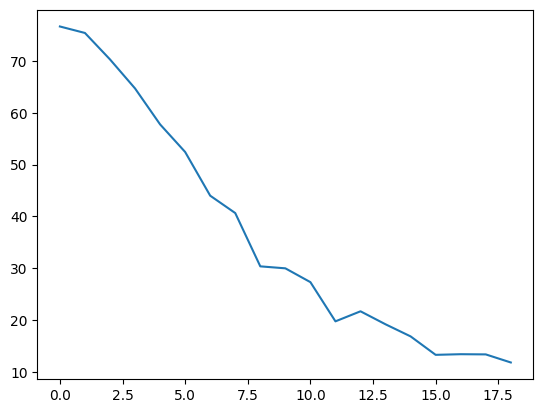

In [12]:
def testmain(model):
    test_loss = 0.
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    matrix = np.zeros((10,10))
    train_on_gpu = torch.cuda.is_available()
    model.eval()
    # iterate over test data
    for data, target in testloader:
        # move tensors to GPU if CUDA is available
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output1 = model(data)
        # calculate the batch loss
        _, pred = torch.max(output1, 1)    
        # compare predictions to true label
      #  print(pred)
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(100):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    test_loss = test_loss/len(testloader.dataset)
    return (100. * np.sum(class_correct) / np.sum(class_total))
avgacc =[]
for i in range(10):
    acchist= []
    for i in range(1,20):
        model = resnet20(10)
        model.load_state_dict(torch.load("/notebooks/overalltop"))
        with torch.no_grad():
            for param in model.parameters():
                param.add_(torch.randn(param.size()) * 0.002*i)
        model.to(device)
        acc = testmain(model)
        acchist.insert(len(acchist),acc)
    if avgacc==[]:
        avgacc = acchist
    else:
        avgacc = [sum(i) for i in zip(avgacc, acchist )]  
        print(avgacc)
avgacc = np.array(avgacc)
avgacc =avgacc/10
plt.plot(avgacc)

[179.05, 180.4, 180.47500000000002, 178.52499999999998, 177.875, 176.775, 172.1, 174.5, 152.025, 167.25, 163.5, 153.375, 166.45, 145.5, 160.35, 137.475, 153.45, 138.725, 140.95, 134.7]
[268.975, 270.0, 268.82500000000005, 262.625, 266.825, 265.2, 257.675, 259.85, 224.575, 253.775, 248.475, 233.425, 237.85, 225.625, 235.2, 204.975, 220.1, 207.675, 207.475, 203.85]
[358.225, 359.525, 359.20000000000005, 346.5, 354.6, 353.35, 346.025, 344.375, 309.875, 327.7, 334.275, 312.55, 318.525, 296.125, 306.95, 271.925, 281.625, 270.02500000000003, 280.675, 272.85]
[448.175, 449.17499999999995, 449.50000000000006, 436.225, 440.5, 441.1, 431.325, 418.325, 385.85, 413.775, 411.47499999999997, 392.4, 389.04999999999995, 375.875, 375.575, 350.45000000000005, 349.7, 341.625, 348.57500000000005, 347.375]


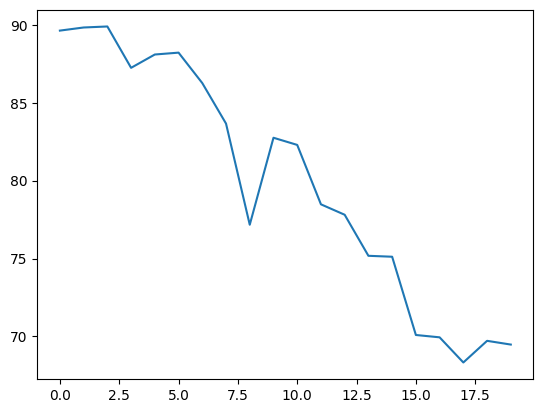

In [11]:
def test(vehicle,airship,cartruck):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    train_on_gpu = torch.cuda.is_available()
    matrix = np.zeros((10,10))
    vehicle.eval()
    cartruck.eval()
    airship.eval()
    for data, target in testloader:
            data, target = data.to(device), target.to(device)
            if target <= 1 or target > 7:
                output2 = vehicle(data)
                _, pred2 = torch.max(output2, 1)
                if pred2 == 0:
                    output3 = airship(data)
                    _, pred3 = torch.max(output3, 1)
                   # print(pred3)
                    predfinal = pred3
                    if pred3[0] != 0:
                        predfinal = pred3 + 7
                if pred2 == 1:
                    output3 = cartruck(data)
                    _, pred3 = torch.max(output3, 1)
                    predfinal = pred3
                  #  print(pred3)
                   # print(target)
                    if pred3 == 0:
                        predfinal =predfinal + 1
                    else:                    
                        predfinal =predfinal + 8   
                correct_tensor = predfinal.eq(target.data.view_as(predfinal))
                correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
                label = target.data[0]
                class_correct[label] += correct.item()
                class_total[label] += 1
                matrix[label][predfinal] +=1
    return 100. * np.sum(class_correct) / np.sum(class_total)
avgacc =[]
for a in range(5):
    acchist= []
    for i in range(1,21):
        vehicle = resnetlowest(2)
        cartruck = resnetlowest(2)
        airship = resnetlowest(2)
        vehicle.load_state_dict(torch.load("vehicletreetop"))
        cartruck.load_state_dict(torch.load("cartrucktreetop"))
        airship.load_state_dict(torch.load("airshiptreetop"))
        with torch.no_grad():
            for param in vehicle.parameters():
                param.add_(torch.randn(param.size()) * 0.002*i)
        with torch.no_grad():
            for param in airship.parameters():
                param.add_(torch.randn(param.size()) * 0.002*i)
        with torch.no_grad():
            for param in cartruck.parameters():
                param.add_(torch.randn(param.size()) * 0.002*i)
        cartruck.to(device)
        airship.to(device)
        vehicle.to(device)
        acc = test(vehicle,airship,cartruck)
        acchist.insert(len(acchist),acc)
    if avgacc==[]:
        avgacc = acchist
    else:
        avgacc = [sum(i) for i in zip(avgacc, acchist )]  
        print(avgacc)
avgacc = np.array(avgacc)
avgacc =avgacc/5
plt.plot(avgacc)


[148.62, 145.6, 135.31, 127.64999999999999, 108.96000000000001, 100.83000000000001, 86.16, 65.9, 89.13, 67.78999999999999, 35.14, 56.41, 44.51, 39.04, 44.2, 31.25, 26.520000000000003, 29.85, 32.95, 29.82]
[223.04000000000002, 215.44, 205.93, 191.56, 171.66000000000003, 150.46, 118.97999999999999, 117.93, 128.34, 92.19, 54.31, 68.42999999999999, 56.43, 55.9, 62.620000000000005, 43.6, 39.57000000000001, 52.64, 39.64, 40.41]
[297.93, 288.77, 272.85, 260.55, 233.85000000000002, 197.83, 173.2, 162.21, 164.16, 127.84, 87.44, 95.97999999999999, 78.17, 75.92, 80.35000000000001, 58.39, 49.540000000000006, 71.6, 59.57, 56.449999999999996]
[372.84000000000003, 362.44, 341.16, 323.64, 296.56, 253.02, 221.92999999999998, 202.09, 206.72, 159.86, 115.92, 121.74999999999999, 99.13, 100.25, 96.59, 75.18, 66.68, 84.13, 75.46000000000001, 66.84]


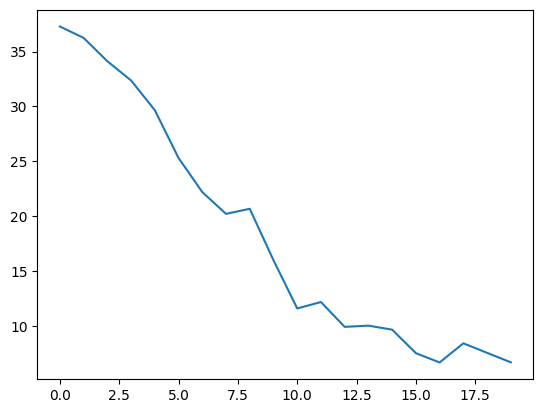

In [11]:
def test(binary,animal,vehicle):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    train_on_gpu = torch.cuda.is_available()
    matrix = np.zeros((10,10))
    binary.eval()
    animal.eval()
    vehicle.eval()
    for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output1 = binary(data)
            _, pred = torch.max(output1, 1) 
            if pred == 0:
                output2 = vehicle(data)
                _, pred2 = torch.max(output2, 1)
                predfinal = pred2
                if predfinal > 1:
                    predfinal = predfinal + 6
            if pred == 1:
                output2 = animal(data)
                _, pred2 = torch.max(output2, 1)
                predfinal = pred2 + 2   
            correct_tensor = predfinal.eq(target.data.view_as(predfinal))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            label = target.data[0]
            class_correct[label] += correct.item()
            class_total[label] += 1
            matrix[label][predfinal] +=1
    return 100. * np.sum(class_correct) / np.sum(class_total)


avgacc =[]
for a in range(5):
    acchist= []
    for i in range(1,21):
        binary = resnetlowest(2)
        animal = resnet20(6)
        vehicle = resnet20(4)
        binary.load_state_dict(torch.load("binarytreetop"))
        animal.load_state_dict(torch.load("animalmaintop"))
        vehicle.load_state_dict(torch.load("vehiclemaintop"))
        with torch.no_grad():
            for param in binary.parameters():
                param.add_(torch.randn(param.size()) * 0.002*i)
        with torch.no_grad():
            for param in animal.parameters():
                param.add_(torch.randn(param.size()) * 0.002*i)
        with torch.no_grad():
            for param in vehicle.parameters():
                param.add_(torch.randn(param.size()) * 0.002*i)
        binary.to(device)
        animal.to(device)
        vehicle.to(device)
        acc = test(binary,animal,vehicle)
        acchist.insert(len(acchist),acc)
    if avgacc==[]:
        avgacc = acchist
    else:
        avgacc = [sum(i) for i in zip(avgacc, acchist )]  
        print(avgacc)
avgacc = np.array(avgacc)
avgacc =avgacc/5
plt.plot(avgacc)

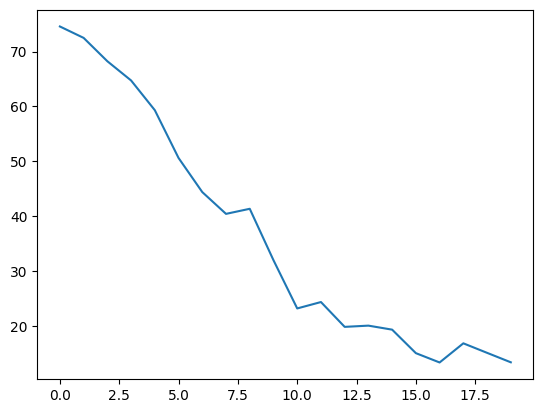

In [12]:
avgacc = avgacc*2
plt.plot(avgacc)

[68.53, 64.64, 65.48, 65.94, 60.23, 59.06, 57.73, 44.28, 43.62, 52.85, 25.6, 42.01, 51.77, 33.25, 34.14, 25.43, 18.03, 20.54, 18.88, 34.33]
[137.09, 131.86, 124.84, 122.5, 123.1, 117.26, 105.82, 92.19, 86.02, 100.92, 72.49000000000001, 84.71000000000001, 83.7, 58.75, 64.15, 63.83, 52.52, 57.91, 49.379999999999995, 65.89]
[206.05, 199.46, 190.39, 189.15, 176.41, 180.02, 157.99, 139.71, 131.49, 146.74, 121.84, 113.55000000000001, 120.63, 78.63, 95.57000000000001, 82.92, 82.75, 90.59, 73.32, 98.75]
[274.45000000000005, 262.58, 258.5, 255.81, 232.88, 230.64000000000001, 210.49, 188.49, 179.31, 195.18, 171.96, 145.24, 170.73, 119.71, 129.02, 121.68, 117.34, 112.43, 106.02, 119.03]
[342.94000000000005, 330.67999999999995, 323.67, 311.12, 290.28, 291.52000000000004, 267.61, 246.43, 228.12, 247.26, 203.72, 188.39000000000001, 215.82, 138.79, 153.57000000000002, 156.33, 148.09, 132.84, 138.87, 153.01]


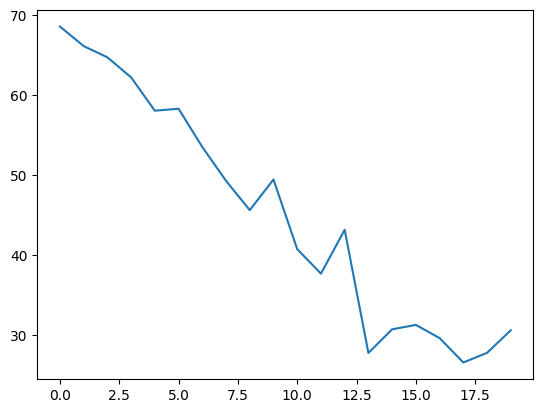

In [11]:
def test(model1, animal, catdog,deerhorse,vehicle,cartruck,airship):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    train_on_gpu = torch.cuda.is_available()
    model1.eval()
    animal.eval()
    catdog.eval()
    deerhorse.eval()
    vehicle.eval()
    cartruck.eval()
    airship.eval()
    for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output1 = model1(data)
            _, pred = torch.max(output1, 1) 
            if pred == 0:
                output2 = vehicle(data)
                _, pred2 = torch.max(output2, 1)
                if pred2 == 0:
                    output3 = airship(data)
                    _, pred3 = torch.max(output3, 1)
                   # print(pred3)
                    predfinal = pred3
                    if pred3 != 0:
                        predfinal = pred3 + 7
                if pred2 == 1:
                    output3 = cartruck(data)
                    _, pred3 = torch.max(output3, 1)
                    predfinal = pred3
                    if pred3 == 0:
                        predfinal =predfinal + 1
                    else:                    
                        predfinal =predfinal + 8   
            if pred == 1:
                output2 = animal(data)
                _, pred2 = torch.max(output2, 1)
                if pred2 == 0:
                    output3 = catdog(data)
                    _, pred3 = torch.max(output3, 1)
                    predfinal = pred3
                    if pred3 < 2:
                        predfinal = pred3 + 2 
                    else:
                        predfinal = pred3 + 3
                if pred2 == 1:   
                    output3 = deerhorse(data)
                    _, pred3 = torch.max(output3, 1)
                    predfinal = pred3
                    if pred3 == 0:
                        predfinal = pred3 + 4 
                    else:
                        predfinal = pred3 + 5 
                        
                    
            correct_tensor = predfinal.eq(target.data.view_as(predfinal))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            label = target.data[0]
            class_correct[label] += correct.item()
            class_total[label] += 1
    return 100. * np.sum(class_correct) / np.sum(class_total)
avgacc =[]
for a in range(5):
    acchist= []
    for i in range(1,21):
        model1 = resnetlowest(2)
        animal = resnetlowest(2)
        vehicle = resnetlowest(2)
        cartruck = resnetlowest(2)
        airship = resnetlowest(2)
        catdog = resnetlowest(3)
        deerhorse = resnetlowest(3)
        model1.load_state_dict(torch.load("binarytreetop"))
        animal.load_state_dict(torch.load("animaltreetop"))
        vehicle.load_state_dict(torch.load("vehicletreetop"))
        cartruck.load_state_dict(torch.load("cartrucktreetop"))
        airship.load_state_dict(torch.load("airshiptreetop"))
        catdog.load_state_dict(torch.load("birdcatdogtop"))
        deerhorse.load_state_dict(torch.load("deerfroghorsetop"))
        with torch.no_grad():
            for param in model1.parameters():
                param.add_(torch.randn(param.size()) * 0.002*i)
        with torch.no_grad():
            for param in animal.parameters():
                param.add_(torch.randn(param.size()) * 0.002*i)
        with torch.no_grad():
            for param in vehicle.parameters():
                param.add_(torch.randn(param.size()) * 0.002*i)
        with torch.no_grad():
            for param in cartruck.parameters():
                param.add_(torch.randn(param.size()) * 0.002*i)
        with torch.no_grad():
            for param in airship.parameters():
                param.add_(torch.randn(param.size()) * 0.002*i)
        with torch.no_grad():
            for param in catdog.parameters():
                param.add_(torch.randn(param.size()) * 0.002*i)
        with torch.no_grad():
            for param in deerhorse.parameters():
                param.add_(torch.randn(param.size()) * 0.002*i)
        cartruck.to(device)
        airship.to(device)
        model1.to(device)
        animal.to(device)
        catdog.to(device)
        deerhorse.to(device)
        vehicle.to(device)
        cartruck.to(device)
        airship.to(device)
        acc = test(model1, animal, catdog,deerhorse,vehicle,cartruck,airship)
        acchist.insert(len(acchist),acc)
    if avgacc==[]:
        avgacc = acchist
    else:
        avgacc = [sum(i) for i in zip(avgacc, acchist)]  
    print(avgacc)
avgacc = np.array(avgacc)
avgacc =avgacc/5
plt.plot(avgacc)


In [ ]:
def l2norm(data): 
  #  matrix = data.numpy()
    count = 0
    total = 0
    for i in range(5):
        for j in range(i+1, 5):
            data1 = matrix[i]
            data2 = matrix[j]
            difference = data1 -data2
            total += np.linalg.norm(difference)
            count = count+1
    print(total/count)
    print(np.linalg.norm(matrix[0]))
    print((total/count)/np.linalg.norm(matrix[0]))

In [ ]:
matrix = np.load('cartrucktree5.npy', allow_pickle = True)
l2norm(matrix)

In [ ]:
matrix = np.load('vehiclemain5.npy', allow_pickle = True)
print(matrix)
l2norm(matrix)